In [1]:
import sys
import pandas as pd
import time as time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.lines import Line2D
import numba
import scienceplots
plt.style.use('science')

# Load data

In [2]:
# Main detectors
dssd = pd.read_csv('processed_data/dssd_non_vetoed_events.csv') # non-vetoed, calibrated dssd events 
ppac = pd.read_csv('processed_data/ppac_events.csv') # raw, uncalibrated
ruth = pd.read_csv('processed_data/rutherford_events.csv')

# DSSD regions
imp = dssd[dssd['event_type'] == 'imp']
boxE = dssd[dssd['event_type'] == 'boxE']
boxW = dssd[dssd['event_type'] == 'boxW']
boxT = dssd[dssd['event_type'] == 'boxT']
boxB = dssd[dssd['event_type'] == 'boxB']

# PPAC 
cathode = ppac[ppac['detector'] == 'cathode']
anodeV = ppac[ppac['detector'] == 'anodeV']
anodeH = ppac[ppac['detector'] == 'anodeH']

# Rutherfords
ruth_E = ruth[ruth['detector'] == 'ruthE']
ruth_W = ruth[ruth['detector'] == 'ruthW']

# PPAC-SHREC coincidences

In [3]:
# Coincidence window
window_before_ns = 1700  # 1700 ns (1.7 us) before
window_after_ns = 0   # 1000 ns (1 us) after

# Convert to picoseconds for use with timetag values
window_before_ps = window_before_ns * 1000  # ns to ps
window_after_ps = window_after_ns * 1000    # ns to ps

In [4]:
# Sort dfs by time (should already be sorted)
cathode_sorted = cathode.sort_values('timetag').reset_index(drop=True)
anodeV_sorted = anodeV.sort_values('timetag').reset_index(drop=True)
anodeH_sorted = anodeH.sort_values('timetag').reset_index(drop=True)
imp_sorted = imp.sort_values('tagx').reset_index(drop=True)  # Using tagx for IMP

In [5]:
# Grab timetag vals (faster searching)
cathode_timetags = cathode_sorted['timetag'].values
anodeV_timetags = anodeV_sorted['timetag'].values
anodeH_timetags = anodeH_sorted['timetag'].values
imp_timetags = imp_sorted['tagx'].values  # Using tagx as the IMP timetag

In [6]:
# Function to find PPAC events within the time window
def find_events_in_window(imp_timetag, detector_timetags, window_before_ps, window_after_ps):
    """
    Find ppac events that occur within the specified time window around the IMP event.
    All time values are in picoseconds.
    
    Params:
    -----------
    imp_timetag : Timestamp of the IMP event in picoseconds
    detector_timetags : Array of detector timestamps in picoseconds
    window_before_ps : Time window before the IMP event in picoseconds
    window_after_ps : Time window after the IMP event in picoseconds
        
    Returns:
    --------
    Indices of events within the window
    """
    # Calculate the time bounds
    lower_bound = imp_timetag - window_before_ps  # Time window before IMP
    upper_bound = imp_timetag + window_after_ps   # Time window after IMP
    
    # Find all events within these bounds using binary search 
    lower_idx = np.searchsorted(detector_timetags, lower_bound)
    upper_idx = np.searchsorted(detector_timetags, upper_bound)
    
    if upper_idx > lower_idx:
        return list(range(lower_idx, upper_idx))
    return []

# Start timing the search
start_time = time.time()

# Create list to store coincident events
coincident_events = []
non_ppac_coincident_events = []

# Number of IMP events to process
total_imp_events = len(imp_sorted)
print(f"Processing {total_imp_events} IMP events...")

# For each IMP event, find coincident PPAC signals
for idx, imp_row in imp_sorted.iterrows():
    imp_timetag = imp_row['tagx'] # remember we are using tagx for the timetag here
    
    # Find ppac events in time window
    cathode_indices = find_events_in_window(imp_timetag, cathode_timetags, window_before_ps, window_after_ps)
    anodeV_indices = find_events_in_window(imp_timetag, anodeV_timetags, window_before_ps, window_after_ps)
    anodeH_indices = find_events_in_window(imp_timetag, anodeH_timetags, window_before_ps, window_after_ps)
    
    # Only proceed if we have coincidences in all three PPAC detectors - AND condition here
    if cathode_indices and anodeV_indices and anodeH_indices:
        
        # Find the closest event in each detector (smallest absolute time difference)
        cathode_diffs = np.abs(cathode_timetags[cathode_indices] - imp_timetag)
        anodeV_diffs = np.abs(anodeV_timetags[anodeV_indices] - imp_timetag)
        anodeH_diffs = np.abs(anodeH_timetags[anodeH_indices] - imp_timetag)
        
        closest_cathode_idx = cathode_indices[np.argmin(cathode_diffs)]
        closest_anodeV_idx = anodeV_indices[np.argmin(anodeV_diffs)]
        closest_anodeH_idx = anodeH_indices[np.argmin(anodeH_diffs)]
        
        # Get the corresponding rows
        cathode_data = cathode_sorted.iloc[closest_cathode_idx]
        anodeV_data = anodeV_sorted.iloc[closest_anodeV_idx]
        anodeH_data = anodeH_sorted.iloc[closest_anodeH_idx]
        
        # Calculate time difference values (in picoseconds)
        # +ve = PPAC after IMP, -ve = PPAC before IMP
        dt_cathode_ps = cathode_data['timetag'] - imp_timetag
        dt_anodeV_ps = anodeV_data['timetag'] - imp_timetag
        dt_anodeH_ps = anodeH_data['timetag'] - imp_timetag
        
        # Create event data dictionary with all relevant information
        event_data = {
            # IMP data
            'imp_timetag': imp_timetag,
            'imp_x': imp_row['x'],
            'imp_y': imp_row['y'],
            'imp_tagx': imp_row['tagx'],
            'imp_tagy': imp_row['tagy'],
            'imp_nfile': imp_row['nfile'],
            'imp_tdelta': imp_row['tdelta'],
            'imp_nX': imp_row['nX'],
            'imp_nY': imp_row['nY'],
            'imp_xE': imp_row['xE'],
            'imp_yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
            
            # Cathode data
            'cathode_timetag': cathode_data['timetag'],
            'cathode_energy': cathode_data['energy'],
            'cathode_board': cathode_data['board'],
            'cathode_channel': cathode_data['channel'],
            'cathode_nfile': cathode_data['nfile'],
            
            # AnodeV data
            'anodeV_timetag': anodeV_data['timetag'],
            'anodeV_energy': anodeV_data['energy'],
            'anodeV_board': anodeV_data['board'],
            'anodeV_channel': anodeV_data['channel'],
            'anodeV_nfile': anodeV_data['nfile'],
            
            # AnodeH data
            'anodeH_timetag': anodeH_data['timetag'],
            'anodeH_energy': anodeH_data['energy'],
            'anodeH_board': anodeH_data['board'],
            'anodeH_channel': anodeH_data['channel'],
            'anodeH_nfile': anodeH_data['nfile'],
            
            # Time difference values (in picoseconds)
            'dt_cathode_ps': dt_cathode_ps,
            'dt_anodeV_ps': dt_anodeV_ps,
            'dt_anodeH_ps': dt_anodeH_ps,
            
            # Convert to nanoseconds for convenience
            'dt_cathode_ns': dt_cathode_ps / 1000,
            'dt_anodeV_ns': dt_anodeV_ps / 1000,
            'dt_anodeH_ns': dt_anodeH_ps / 1000
        }
        
        coincident_events.append(event_data)
    else:
        non_coincident_data = {
            # IMP data
            'timetag': imp_timetag,
            't':imp_timetag / 1e12,
            'x': imp_row['x'],
            'y': imp_row['y'],
            'tagx': imp_row['tagx'],
            'tagy': imp_row['tagy'],
            'nfile': imp_row['nfile'],
            'tdelta': imp_row['tdelta'],
            'nX': imp_row['nX'],
            'nY': imp_row['nY'],
            'xE': imp_row['xE'],
            'yE': imp_row['yE'],
            'xboard': imp_row['xboard'],
            'yboard': imp_row['yboard'],
        }
        
        non_ppac_coincident_events.append(non_coincident_data)
        
        # TODO - Since we use an AND condition between the ppac plates, we need to add a condition in to
        #        make sure theres no ppac signal at all.
    
    # Print progress every 10,000 events
    if idx % 10000 == 0 and idx > 0:
        elapsed = time.time() - start_time
        events_per_sec = idx / elapsed
        remaining_time = (total_imp_events - idx) / events_per_sec if events_per_sec > 0 else 0
        print(f"Processed {idx}/{total_imp_events} events ({idx/total_imp_events*100:.1f}%) - Rate: {events_per_sec:.1f} events/sec - ETA: {remaining_time:.1f} sec")

# Create the df with coincident events
coincident_imp_df = pd.DataFrame(coincident_events)
non_coincident_imp_df = pd.DataFrame(non_ppac_coincident_events)
print(f"Found {len(coincident_imp_df)} coincidences within the window")

# Calculate total processing time
elapsed_time = time.time() - start_time
print(f"Total processing time: {elapsed_time:.2f} seconds")
print(f"Processing rate: {total_imp_events/elapsed_time:.1f} events/second")



Processing 297694 IMP events...
Processed 10000/297694 events (3.4%) - Rate: 10221.5 events/sec - ETA: 28.1 sec
Processed 20000/297694 events (6.7%) - Rate: 10364.7 events/sec - ETA: 26.8 sec
Processed 30000/297694 events (10.1%) - Rate: 10679.3 events/sec - ETA: 25.1 sec
Processed 40000/297694 events (13.4%) - Rate: 10812.3 events/sec - ETA: 23.8 sec
Processed 50000/297694 events (16.8%) - Rate: 10926.7 events/sec - ETA: 22.7 sec
Processed 60000/297694 events (20.2%) - Rate: 10997.6 events/sec - ETA: 21.6 sec
Processed 70000/297694 events (23.5%) - Rate: 11049.4 events/sec - ETA: 20.6 sec
Processed 80000/297694 events (26.9%) - Rate: 11101.3 events/sec - ETA: 19.6 sec
Processed 90000/297694 events (30.2%) - Rate: 11130.4 events/sec - ETA: 18.7 sec
Processed 100000/297694 events (33.6%) - Rate: 11174.7 events/sec - ETA: 17.7 sec
Processed 110000/297694 events (37.0%) - Rate: 11208.9 events/sec - ETA: 16.7 sec
Processed 120000/297694 events (40.3%) - Rate: 11230.7 events/sec - ETA: 15.8

# Plot raw etof

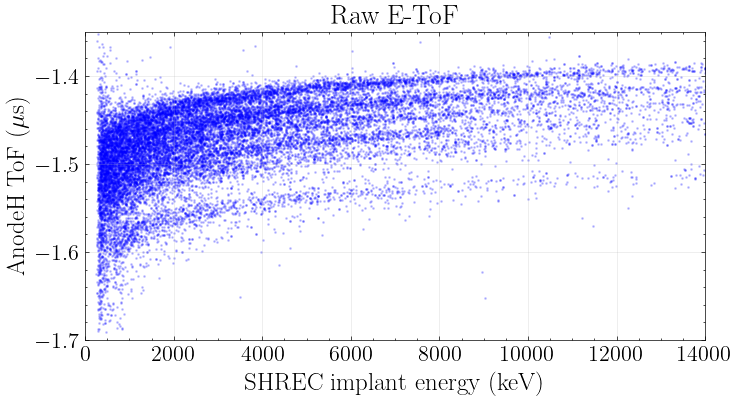

In [7]:
if not coincident_imp_df.empty:
    # Convert ns time differences to us for plotting
    coincident_imp_df['dt_cathode_us'] = coincident_imp_df['dt_cathode_ns'] / 1000  # ns to μs
    coincident_imp_df['dt_anodeV_us'] = coincident_imp_df['dt_anodeV_ns'] / 1000    # ns to μs
    coincident_imp_df['dt_anodeH_us'] = coincident_imp_df['dt_anodeH_ns'] / 1000    # ns to μs
    
    plt.figure(figsize=(8, 4))
    fs = 18
    plt.scatter(coincident_imp_df['imp_xE'], coincident_imp_df['dt_anodeH_us'], 
                alpha=0.2, s=1, c='blue')
    plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
    plt.ylabel(r"AnodeH ToF ($\mu$s)", fontsize=fs)
    plt.title("Raw E-ToF", fontsize=fs+2)
    plt.xlim(0, 14000)
    plt.ylim(-1.7, -1.35)
    plt.grid(True, alpha=0.3)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=fs-2)
#     plt.legend(fontsize=fs-4, frameon=True)
    plt.savefig("plots/raw_etof.pdf", dpi=1000)
else:
    print("No coincidences")

# Time correction for SHREC imp region boards

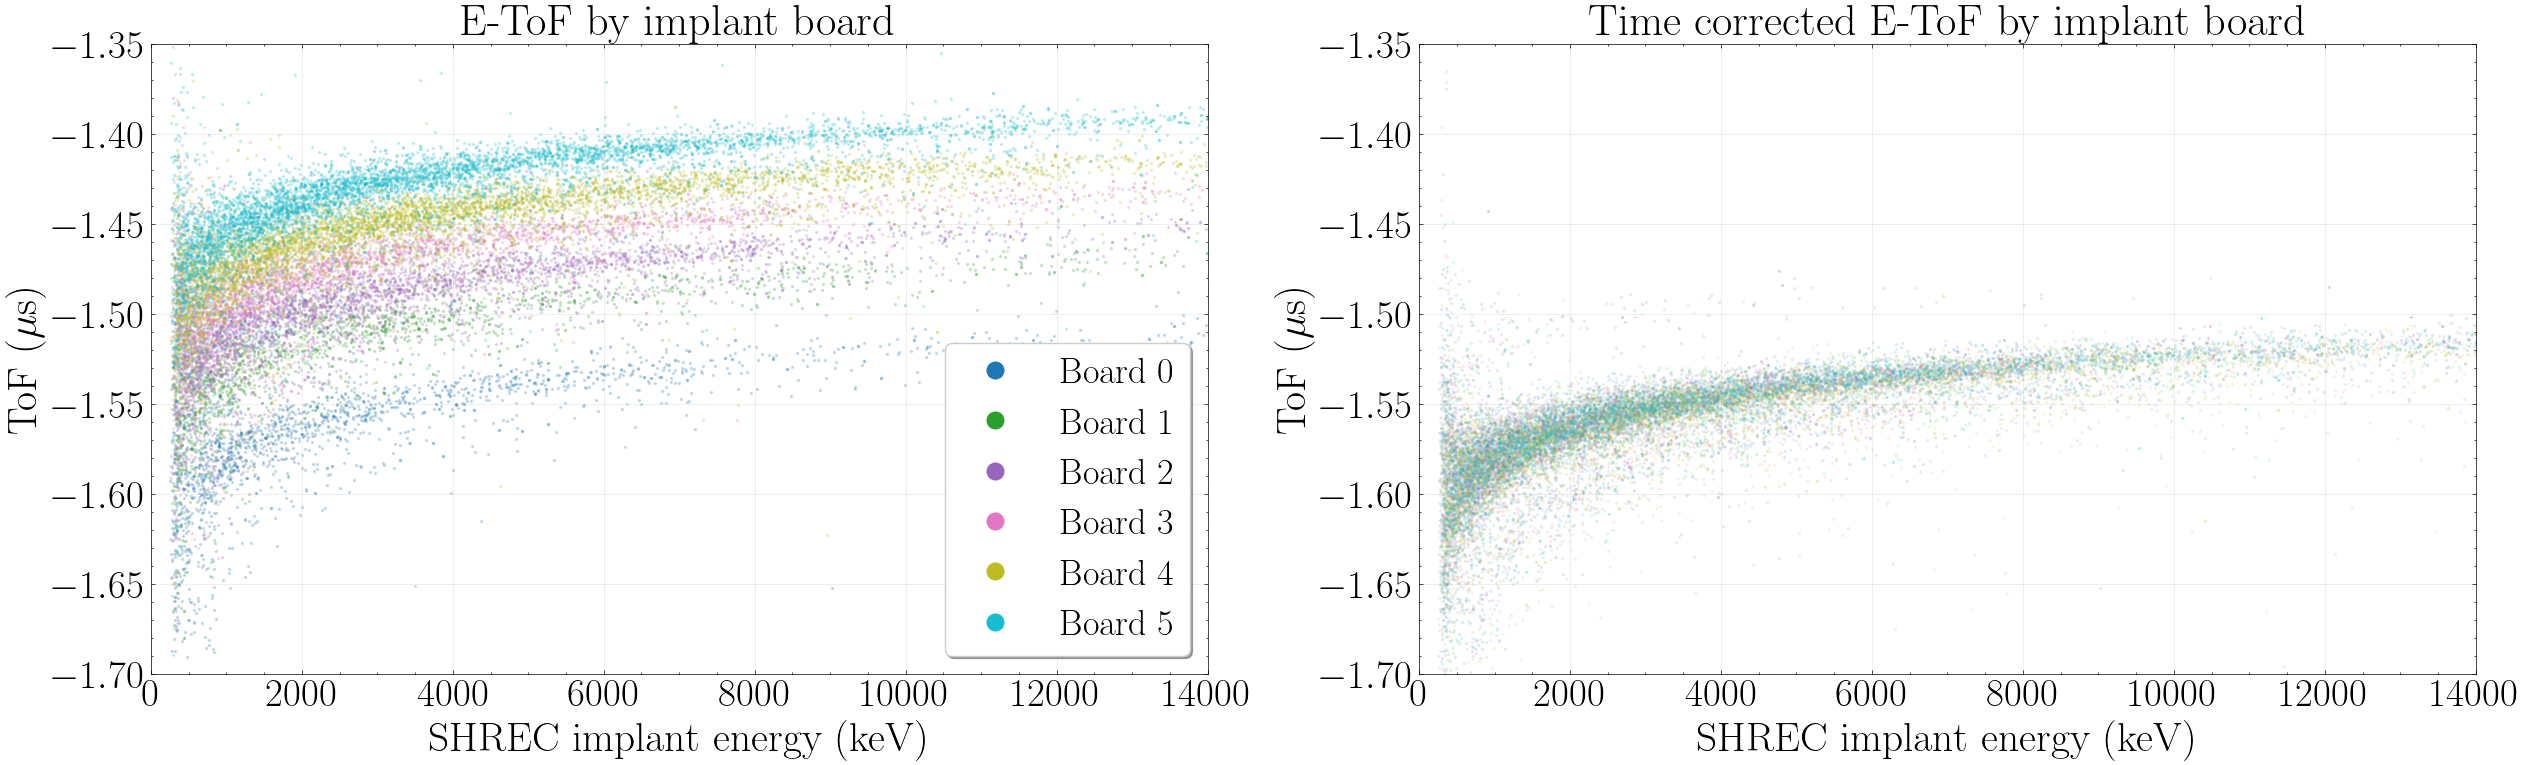

In [8]:
from matplotlib.lines import Line2D

# Get the recoil time in seconds
coincident_imp_df['t'] = coincident_imp_df['imp_timetag'] * 1e-12

# Define manual time offsets for the boards- board0 is master
manual_offsets = {
    0: 0,
    1: -0.045e-6,
    2: -0.065e-6,
    3: -0.085e-6,
    4: -0.105e-6,
    5: -0.125e-6,
}

# Calculate the corrected dt for the ppac plates in microseconds
# Staying consistent with xboard
coincident_imp_df['dt_anodeH_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_anodeH_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp_df['dt_anodeV_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_anodeV_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

coincident_imp_df['dt_cathode_us_corr'] = coincident_imp_df.apply(
    lambda row: row['dt_cathode_us'] + manual_offsets.get(row['xboard'], 0) * 1e6,
    axis=1
)

# Get boards
boards = sorted(coincident_imp_df['xboard'].unique())

plt.figure(figsize=(30,18))
fs=30

plt.subplot(221)
colors = plt.cm.tab10(np.linspace(0, 1, len(boards)))
legend_handles = []

for board, color in zip(boards, colors):
    # Filter the df for this board
    board_data = coincident_imp_df[coincident_imp_df['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us'],
                s=2, alpha=0.2, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True, shadow=True, facecolor='white')

plt.subplot(222)
for board, color in zip(boards, colors):
    # Filter the DataFrame for this board
    board_data = coincident_imp_df[coincident_imp_df['xboard'] == board]
    plt.scatter(board_data['imp_xE'], board_data['dt_anodeH_us_corr'],
                s=2, alpha=0.1, color=color, label=f'Board {board}')
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markersize=14, markerfacecolor=color, label=f'Board {board}'))
plt.xlabel("SHREC implant energy (keV)", fontsize=fs)
plt.ylabel(r"ToF ($\mu$s)", fontsize=fs)
plt.title("Time corrected E-ToF by implant board", fontsize=fs+2)
plt.xlim(0, 14000)
plt.ylim(-1.7, -1.35)
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(handles=legend_handles, fontsize=fs-4, frameon=True)


plt.savefig("plots/etof_by_board.png", dpi=1000)


# Decay events

In [9]:
# Set decay time window
min_corr_time = 0.00000001     # Minimum time after recoil to consider (in seconds)
max_corr_time = 20     # Maximum time after recoil to consider (in seconds)

In [10]:
# Build pixel history from the imp df & group the full implant event history by pixel (x,y)
pixel_groups = imp.groupby(['x', 'y'])
pixel_history = {pixel: group for pixel, group in pixel_groups}

In [11]:
# Create decay event list
decay_events = []

In [12]:
# For each recoil event, search for subsequent events in the same pixel from imp

# Create decay events list to hold events
decay_candidates = []  

# Loop through coincident imp (recoil-like) events
for recoil_idx, recoil in coincident_imp_df.iterrows():
    
    # Get the pixel for the recoil event
    pixel = (recoil['imp_x'], recoil['imp_y'])
    
    # Convert the recoil imp_timetag from picoseconds to seconds
    recoil_time_sec = recoil['imp_timetag'] / 1e12
    
    # Check if there are any events in the same pixel in the imp region df.
    if pixel not in pixel_history:
        continue  # Skip if no events are found for this pixel
    
    # Get the time sorted events for this pixel from imp
    pixel_df = pixel_history[pixel]
    
    # Get the pixel time values as a sorted array
    time_array = pixel_df['t'].values # This is in seconds
    
    # Define the lower and upper bounds for candidate decay events in seconds
    lower_bound = recoil_time_sec + min_corr_time
    upper_bound = recoil_time_sec + max_corr_time
    
    # Use binary search to find the index positions in the time array
    start_idx = np.searchsorted(time_array, lower_bound, side='left')
    end_idx = np.searchsorted(time_array, upper_bound, side='right')
    
    # If events exist in the correlation window, add them as candidate decay events
    if start_idx < end_idx:
        
        candidate_events = pixel_df.iloc[start_idx:end_idx].copy()
        
        # Record the associated recoil info for later
        candidate_events['recoil_index'] = recoil_idx 
        candidate_events['recoil_time_sec'] = recoil_time_sec
        decay_candidates.append(candidate_events) # add decay candidates to list

# Combine all candidate decay events into a single df
if decay_candidates:
    decay_candidates_df = pd.concat(decay_candidates, ignore_index=True)
else:
    decay_candidates_df = pd.DataFrame()

# Display the first few decay candidates
print(decay_candidates_df.head())


           t    x   y            tagx            tagy  nfile  xboard  yboard  \
0  12.207831   56  55  12207830699996  12207830659994      0       5       6   
1   2.015917   24  28   2015916627529   2015916617593      0       5       7   
2   2.489408   93  21   2489407508998   2489407406746      0       2       6   
3   2.988997  134   9   2988996577495   2988996480004      0       1       6   
4   3.119531   45  15   3119530906871   3119530872682      0       4       6   

   tdelta  nX  nY           xE           yE event_type  recoil_index  \
0   40002   1   1   356.653196   380.381568        imp             2   
1    9936   1   1  5670.440022  5705.073404        imp             6   
2  102252   1   1  1108.284909  1076.659474        imp             8   
3   97491   1   1   744.962768   751.713658        imp            10   
4   34189   1   2  5140.402540  4958.989920        imp            13   

   recoil_time_sec  
0         0.518054  
1         2.015917  
2         2.489408  
3 

# PPAC Anticoincidence check for decays

Check the candidate decay is in the non-coincident list, do this by merging on pixel?


In [13]:
# Check the unique (x, y, t) keys in each DataFrame
print("Decay candidates unique keys:", decay_candidates_df[['x', 'y', 't']].drop_duplicates().shape)
print("Non-coincident unique keys:", non_coincident_imp_df[['x', 'y', 't']].drop_duplicates().shape)


Decay candidates unique keys: (20251, 3)
Non-coincident unique keys: (265829, 3)


In [14]:
if not decay_candidates_df.empty:
    # Drop duplicate rows based on x and y in non_coincident_imp_df
    non_coincident_clean = non_coincident_imp_df[['x', 'y']].drop_duplicates()
    
    # every row in decay_candidates_df is kept, 
    # and we add data from non_coincident_clean where there is a match on x and y
    decay_candidates_df = decay_candidates_df.merge(
        non_coincident_clean, 
        on=['x', 'y'],
        how='left',
        indicator='ppac_flag'
    )
    
    # If an event from decay_candidates_df finds a matching row in non_coincident_clean, 
    # ppac_flag will be set to "both".
    # If there is no match (i.e. PPAC signal), ppac_flag will be 'left_only'
    decay_candidates_df['is_clean'] = decay_candidates_df['ppac_flag'] == 'both'

print(decay_candidates_df['is_clean'].value_counts())
print(decay_candidates_df.head())


is_clean
True    20544
Name: count, dtype: int64
           t    x   y            tagx            tagy  nfile  xboard  yboard  \
0  12.207831   56  55  12207830699996  12207830659994      0       5       6   
1   2.015917   24  28   2015916627529   2015916617593      0       5       7   
2   2.489408   93  21   2489407508998   2489407406746      0       2       6   
3   2.988997  134   9   2988996577495   2988996480004      0       1       6   
4   3.119531   45  15   3119530906871   3119530872682      0       4       6   

   tdelta  nX  nY           xE           yE event_type  recoil_index  \
0   40002   1   1   356.653196   380.381568        imp             2   
1    9936   1   1  5670.440022  5705.073404        imp             6   
2  102252   1   1  1108.284909  1076.659474        imp             8   
3   97491   1   1   744.962768   751.713658        imp            10   
4   34189   1   2  5140.402540  4958.989920        imp            13   

   recoil_time_sec ppac_flag  is_clea

# Decay KHS

In [15]:
# Find the log time between implant and decay event
decay_candidates_df['log_dt'] = np.log(abs(decay_candidates_df['t'] - decay_candidates_df['recoil_time_sec']))

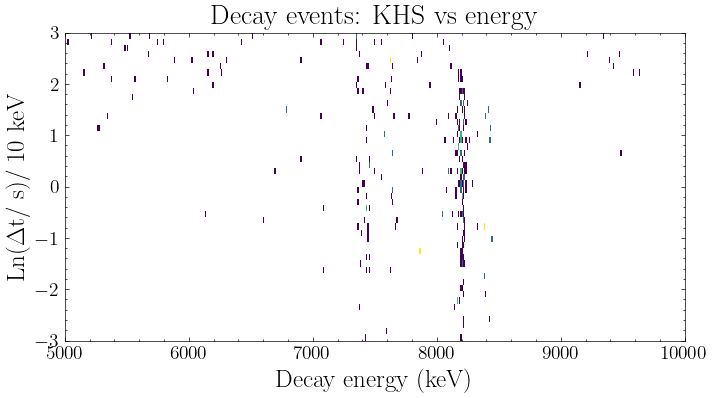

In [16]:
# Plot the 2d KHS hist
fs = 18
plt.figure(figsize=(8,4))
plt.hist2d(decay_candidates_df['yE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((5000,10000),(-3,3)), cmin=1)
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.savefig('plots/decay_khs.pdf', dpi=1000)

# EVR-a correlations

In [17]:
# Alpha energy, time gates
# Recoil energy gates

alpha_energy_min = 8100    # Minimum alpha energy (keV)
alpha_energy_max = 8400    # Maximum alpha energy (keV)

recoil_energy_min = 2000   # Minimum recoil energy (keV)
recoil_energy_max = 8099  # Maximum recoil energy (keV) 

alpha_corr_min = 0.08    # Minimum time difference in seconds 
alpha_corr_max = 10         # Maximum time difference in seconds


In [18]:
# Filter alpha candidates by energy
filtered_alpha_candidates = decay_candidates_df[
    (decay_candidates_df['xE'] >= alpha_energy_min) & 
    (decay_candidates_df['xE'] <= alpha_energy_max)
].copy()

In [19]:
# just making sure we have t
if 't' not in filtered_alpha_candidates.columns:
    filtered_alpha_candidates['t'] = filtered_alpha_candidates['timetag'] / 1e12 

In [20]:
# for each alpha candidate, find the preceeding recoil in same pixel

# initialising cols in the df
filtered_alpha_candidates['closest_recoil_index'] = np.nan
filtered_alpha_candidates['recoil_time'] = np.nan
filtered_alpha_candidates['time_difference'] = np.nan
filtered_alpha_candidates['recoil_energy'] = np.nan

# loop through the alpha candidates
for idx, alpha in filtered_alpha_candidates.iterrows():
    pixel_x = alpha['x']
    pixel_y = alpha['y']
    alpha_time = alpha['t']
    
    # Retrieve all recoil events from the same pixel
    recoils_in_pixel = coincident_imp_df[
        (coincident_imp_df['imp_x'] == pixel_x) & (coincident_imp_df['imp_y'] == pixel_y)
    ]
    
    # apply recoil energy gate
    recoils_in_pixel = recoils_in_pixel[
        (recoils_in_pixel['imp_xE'] >= recoil_energy_min) &
        (recoils_in_pixel['imp_xE'] <= recoil_energy_max)
    ]
    
    # Only consider recoils that occurred before the alpha event
    recoils_before = recoils_in_pixel[recoils_in_pixel['t'] < alpha_time]
    
    if not recoils_before.empty:
        
        # its good to work with copies... compute the time difference between r-a
        recoils_before = recoils_before.copy()
        recoils_before['time_diff'] = alpha_time - recoils_before['t']
        
        # make sure the r-a fits in the coincidence window
        recoils_in_window = recoils_before[
            (recoils_before['time_diff'] >= alpha_corr_min) &
            (recoils_before['time_diff'] <= alpha_corr_max)
        ]
        
        if not recoils_in_window.empty:
            # there might be multiple correlations, so choose the one with the smallest time difference
            closest_recoil = recoils_in_window.loc[recoils_in_window['time_diff'].idxmin()]
            filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = closest_recoil.name
            filtered_alpha_candidates.at[idx, 'recoil_time'] = closest_recoil['t']
            filtered_alpha_candidates.at[idx, 'time_difference'] = closest_recoil['time_diff']
            filtered_alpha_candidates.at[idx, 'recoil_energy'] = closest_recoil['imp_xE']
        else:
            filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = np.nan
            filtered_alpha_candidates.at[idx, 'recoil_time'] = np.nan
            filtered_alpha_candidates.at[idx, 'time_difference'] = np.nan
            filtered_alpha_candidates.at[idx, 'recoil_energy'] = np.nan
    else:
        filtered_alpha_candidates.at[idx, 'closest_recoil_index'] = np.nan
        filtered_alpha_candidates.at[idx, 'recoil_time'] = np.nan
        filtered_alpha_candidates.at[idx, 'time_difference'] = np.nan
        filtered_alpha_candidates.at[idx, 'recoil_energy'] = np.nan


In [21]:
# Build the correlation dataframe
correlated_events = filtered_alpha_candidates.dropna(subset=['recoil_time']).copy()
print("Number of correlated alpha-recoil events:", len(correlated_events))
print(correlated_events.head())

Number of correlated alpha-recoil events: 131
              t    x   y             tagx             tagy  nfile  xboard  \
11    12.080650  122  33   12080649784341   12080649701525      0       1   
63    15.607118   42  57   15607118261338   15607118249062      0       5   
280   67.901936   64  42   67901935608493   67901935543055      0       3   
358   82.634911   42  40   82634910892808   82634910863965      0       5   
581  134.815423   54  33  134815423267185  134815423261684      0       5   

     yboard  tdelta  nX  ...  event_type  recoil_index  recoil_time_sec  \
11        6   82816   1  ...         imp            25         4.180240   
63        6   12276   1  ...         imp           102        14.781984   
280       7   65438   1  ...         imp           457        59.320795   
358       7   28843   1  ...         imp           608        80.733797   
581       6    5501   1  ...         imp           933       133.703990   

    ppac_flag  is_clean    log_dt closes

In [22]:
# Merge the recoil and alpha info together, and rename things for clarity
recoil_rename = {
    'imp_timetag': 'rec_timetag',
    'imp_x': 'rec_x',
    'imp_y': 'rec_y',
    'imp_tagx': 'rec_tagx',
    'imp_tagy': 'rec_tagy',
    'imp_nfile': 'rec_nfile',
    'imp_tdelta': 'rec_tdelta',
    'imp_nX': 'rec_nX',
    'imp_nY': 'rec_nY',
    'imp_xE': 'rec_xE',
    'imp_yE': 'rec_yE',
    'xboard': 'rec_xboard',
    'yboard': 'rec_yboard',
    'cathode_timetag': 'rec_cathode_timetag',
    'cathode_energy': 'rec_cathode_energy',
    'cathode_board': 'rec_cathode_board',
    'cathode_channel': 'rec_cathode_channel',
    'cathode_nfile': 'rec_cathode_nfile',
    'anodeV_timetag': 'rec_anodeV_timetag',
    'anodeV_energy': 'rec_anodeV_energy',
    'anodeV_board': 'rec_anodeV_board',
    'anodeV_channel': 'rec_anodeV_channel',
    'anodeV_nfile': 'rec_anodeV_nfile',
    'anodeH_timetag': 'rec_anodeH_timetag',
    'anodeH_energy': 'rec_anodeH_energy',
    'anodeH_board': 'rec_anodeH_board',
    'anodeH_channel': 'rec_anodeH_channel',
    'anodeH_nfile': 'rec_anodeH_nfile',
    'dt_cathode_ps': 'rec_dt_cathode_ps',
    'dt_anodeV_ps': 'rec_dt_anodeV_ps',
    'dt_anodeH_ps': 'rec_dt_anodeH_ps',
    'dt_cathode_ns': 'rec_dt_cathode_ns',
    'dt_anodeV_ns': 'rec_dt_anodeV_ns',
    'dt_anodeH_ns': 'rec_dt_anodeH_ns',
    'dt_cathode_us': 'rec_dt_cathode_us',
    'dt_anodeV_us': 'rec_dt_anodeV_us',
    'dt_anodeH_us': 'rec_dt_anodeH_us',
    't': 'rec_t',
    'dt_anodeH_us_corr': 'rec_dt_anodeH_us_corr',
    'dt_anodeV_us_corr': 'rec_dt_anodeV_us_corr',
    'dt_cathode_us_corr': 'rec_dt_cathode_us_corr'
}

alpha_rename = {
    't': 'alpha_t',
    'x': 'alpha_x',
    'y': 'alpha_y',
    'tagx': 'alpha_tagx',
    'tagy': 'alpha_tagy',
    'nfile': 'alpha_nfile',
    'xboard': 'alpha_xboard',
    'yboard': 'alpha_yboard',
    'tdelta': 'alpha_tdelta',
    'nX': 'alpha_nX',
    'nY': 'alpha_nY',
    'xE': 'alpha_xE',
    'yE': 'alpha_yE',
    'event_type': 'alpha_event_type',
    'recoil_index': 'alpha_recoil_index',
    'recoil_time_sec': 'alpha_recoil_time',
    'ppac_flag': 'alpha_ppac_flag',
    'is_clean': 'alpha_is_clean',
    'log_dt': 'alpha_log_dt',
    # Also include new computed cols
    'closest_recoil_index': 'alpha_closest_recoil_index',
    'recoil_time': 'alpha_recoil_time_calculated',
    'time_difference': 'alpha_time_difference',
    'recoil_energy': 'alpha_recoil_energy'
}

# Rename columns in the recoil df
recoil_df_renamed = coincident_imp_df.copy().rename(columns=recoil_rename)

# Rename columns in the alpha df
alpha_df_renamed = correlated_events.copy().rename(columns=alpha_rename)

# Merge the two dfs using the recoil index
final_correlated_df = alpha_df_renamed.merge(
    recoil_df_renamed,
    left_on='alpha_recoil_index',
    right_index=True,
    how='left'
)


In [23]:
# print some check stuff
print("Final correlated Events df:")
print(final_correlated_df.head())
print("Checking pixel matches (alpha vs. recoil):")
print(final_correlated_df[['alpha_x', 'alpha_y', 'rec_x', 'rec_y']].head())

Final correlated Events df:
        alpha_t  alpha_x  alpha_y       alpha_tagx       alpha_tagy  \
11    12.080650      122       33   12080649784341   12080649701525   
63    15.607118       42       57   15607118261338   15607118249062   
280   67.901936       64       42   67901935608493   67901935543055   
358   82.634911       42       40   82634910892808   82634910863965   
581  134.815423       54       33  134815423267185  134815423261684   

     alpha_nfile  alpha_xboard  alpha_yboard  alpha_tdelta  alpha_nX  ...  \
11             0             1             6         82816         1  ...   
63             0             5             6         12276         1  ...   
280            0             3             7         65438         1  ...   
358            0             5             7         28843         1  ...   
581            0             5             6          5501         1  ...   

     rec_dt_cathode_ns  rec_dt_anodeV_ns  rec_dt_anodeH_ns rec_dt_cathode_us  \
11

# Plotting correlated stuff

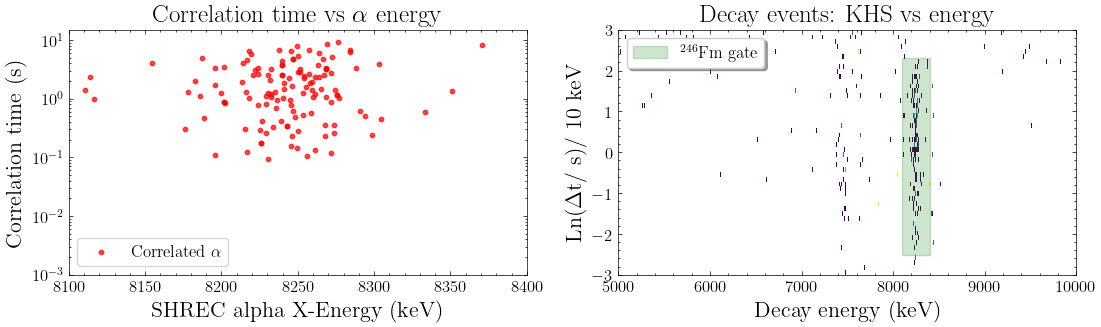

In [24]:
# log decay time

final_correlated_df['log_dt'] = np.log10(np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t']))
final_correlated_df['rec_alpha_time'] =np.abs(final_correlated_df['alpha_t'] - final_correlated_df['rec_t'])
fs = 16
plt.figure(figsize=(13,7))

plt.subplot(221)
plt.scatter(final_correlated_df['alpha_xE'], final_correlated_df['rec_alpha_time'],
            s=10, color='red', alpha=0.7, label=r'Correlated $\alpha$')
plt.xlabel('SHREC alpha X-Energy (keV)', fontsize=fs)
# plt.ylabel(r'log(dt/s)', fontsize=fs)
plt.ylabel(r'Correlation time (s)', fontsize=fs)
plt.xlim(8100, 8400)
plt.yscale('log')
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4 )
plt.legend(fontsize=fs-4, loc='lower left', frameon=True)
plt.ylim(0.001,15)
plt.title(r'Correlation time vs $\alpha$ energy', fontsize=fs+2)

plt.subplot(222)
plt.hist2d(decay_candidates_df['xE'], decay_candidates_df['log_dt'], 
           bins=((500),(50)), range=((5000,10000),(-3,3)), cmin=1)
plt.fill_betweenx(y=[np.log(alpha_corr_min), np.log(alpha_corr_max)], x1=alpha_energy_min, x2=alpha_energy_max, 
                  color='g', alpha=0.2, label=r'$^{246}$Fm gate')
plt.xlabel('Decay energy (keV)', fontsize=fs)
plt.ylabel(r'Ln($\Delta$t/ s)/ 10 keV', fontsize=fs)
plt.title('Decay events: KHS vs energy', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', labelsize=fs-4)
plt.legend(fontsize=fs-4, loc='upper left', frameon=True, facecolor='white', shadow=True)




plt.savefig('plots/log_time_corr_alphas.pdf', dpi=300)

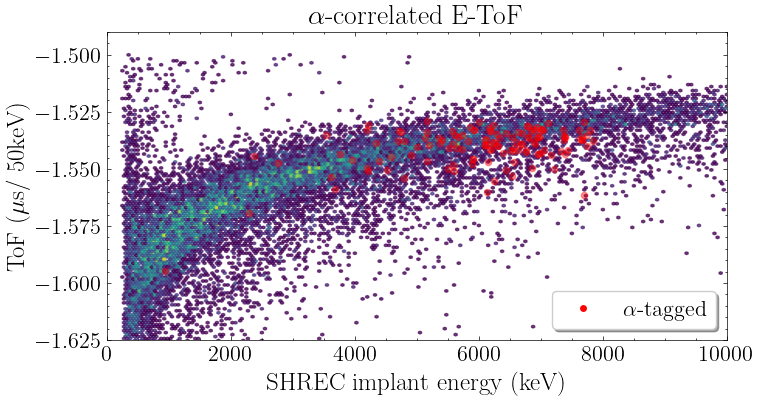

In [29]:
# Correlated etof

plt.figure(figsize=(8,4))
fs = 18
plt.hexbin(coincident_imp_df['imp_xE'], coincident_imp_df['dt_anodeH_us_corr'], 
           gridsize=200, extent=(0, 10000, -1.7, -1.5), mincnt=1, cmap='viridis', alpha=0.7)
plt.scatter(final_correlated_df['rec_xE'], final_correlated_df['rec_dt_anodeH_us_corr'],
            color='red', alpha=0.4, s=20, label=r'$\alpha$-tagged')  
legend_marker = Line2D([0], [0], marker='o', color='w', markersize=6, 
                        markerfacecolor='red', label=r'$\alpha$-tagged')
plt.ylim(-1.625, -1.49)
plt.xlim(0, 10000)
plt.xlabel('SHREC implant energy (keV)', fontsize=fs)
plt.ylabel(r'ToF ($\mu$s/ 50keV)', fontsize=fs)
plt.title(r'$\alpha$-correlated E-ToF', fontsize=fs+2)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
plt.legend(handles=[legend_marker], loc='lower right', fontsize=fs-2, frameon=True, facecolor='white', shadow=True)
plt.savefig('plots/correlated_etof.pdf', dpi=300)

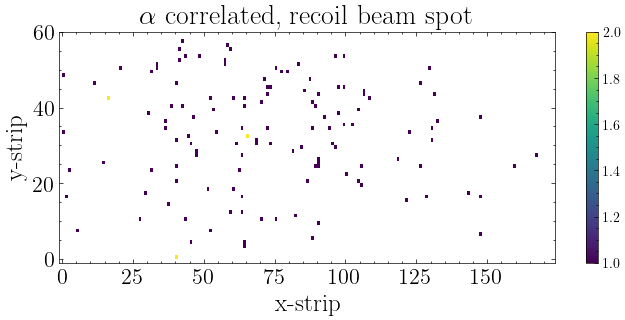

In [26]:
# correlated beam spot
plt.figure(figsize=(8,3))
fs = 18
plt.hist2d(final_correlated_df['rec_x'], final_correlated_df['rec_y'], 
           bins=((175),(61)), range=((-1,174),(-1,60)), cmin=1)
# plt.xlim(0, 10000)
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'y-strip', fontsize=fs)
plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)
# plt.legend(loc='lower right', fontsize=fs-2, frameon=True)
plt.savefig('plots/correlated_stripX_stripY.pdf', dpi=300)

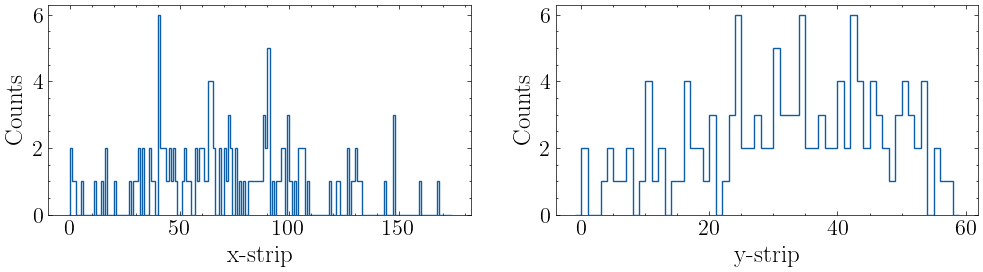

In [27]:
# beam spot projections
# correlated beam spot

plt.figure(figsize=(12,6))
fs = 18

plt.subplot(221)
plt.hist(final_correlated_df['rec_x'], histtype='step', bins=175, range=(-1,174))
plt.xlabel('x-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.subplot(222)
plt.hist(final_correlated_df['rec_y'], histtype='step',bins=60, range=(-1,59))
plt.xlabel('y-strip', fontsize=fs)
plt.ylabel(r'Counts', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)


plt.savefig('plots/correlated_beam_spot_projections.pdf', dpi=300)

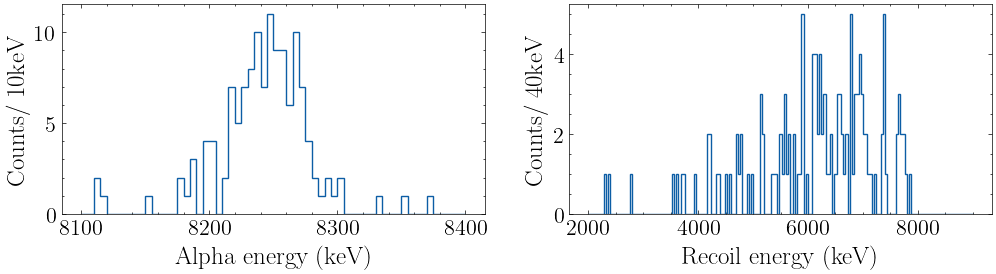

In [28]:
# Recoil and alpha energies

plt.figure(figsize=(12,6))
fs = 18

plt.subplot(221)
plt.hist(final_correlated_df['alpha_xE'], histtype='step', bins=60, range=(8100,8400))
plt.xlabel('Alpha energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 10keV', fontsize=fs)
# plt.title(r'$\alpha$ correlated, recoil beam spot', fontsize=fs+2)
# plt.colorbar()
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.subplot(222)
plt.hist(final_correlated_df['rec_xE'], histtype='step',bins=175, range=(2000,9000))
plt.xlabel('Recoil energy (keV)', fontsize=fs)
plt.ylabel(r'Counts/ 40keV', fontsize=fs)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=fs-2)

plt.savefig('plots/rec_alpha_energy_projections.pdf', dpi=300)